# Sameer Pandya
# spandya@gmail.com
# Forecasting Volcanic Eruption and Impact Assessment

# **Problem Statement and Approach**
The volcano problem provides many observations for 10 volcano readings. These observations capture various experimental parameters which remain constant for that observation and then every observation captures the time units of start to end of the experiment.

There are two problem statements:

1.   Predict the blast value at volcano eruption
2.   Predict the time units until volcano eruption

# Approach
Based on the problem statement, I have taken the following approach predicting Blast values and erupt values. Note that here I have applied these steps to Volcano 1, but they can be repeated for other volcanoes. I chose to run separate regressions for separate volcanoes to keep things simple and consistent. If I were given more time, then I woul consider mixing up the volcanoes to come up with a generic model, but I chose not to take this approach.


1.   Find and eliminate any outliers
2.   Since this is time series data, perform some data transformation so that features can be extracted from this data. I have augmented that data by applying a Sliding Window transforamtion over a window size of 1,000 as explained later.
3.   Use PyCaret to determine the best models that can be used for predicting blast values and erupt values respectively
4. Save 10% of data for unseen cross validation testing
5. Use the remaining 90% data to train the model (with a 70/30) split





In [1]:
pip install -q pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 21.4 MB/s eta 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from pycaret.regression import *


# Helper Function   to load the files
This function *loadDataFiles* accepts *Path, Volcano number and Observation Number as arguments*

It loads the data from the files and prepares following pandas dataframes:

1.   df_h which is the 'header' file containing the erho, sigma and M values from an observation
2.   df_o  which is a raw dataframe of all time and sensor readings associated with the time intervsl
3.   Volcano id
4.   Observation id

**Note:**
Since sensor readings are very small, this function transforms their values by multiplying them with exp(21)






In [20]:
def loadDataFiles(path,volcano,observation):

  df_o =pd.DataFrame({})
  skip_lines = 14  # Skip the first 14 lines (start from the 15th line)
  file_path = path + "/Volcano"+volcano+ "/observation" + observation+ ".txt"

  blast_time = 0
  blast_value = 0
  Intvolcano = int(volcano)
  Intobservation = int(observation)

  # Read first 11 lines into a header file
  custom_column_names = ['Name', 'Value']
  df_h = pd.read_csv(file_path, sep=',',nrows=11,names=custom_column_names)
  #print(df_h)

  ########################################################################

  # Read the CSV file while skipping the specified number of lines
  df_o = pd.read_csv(file_path, skiprows=skip_lines)

  #Transform so that the timestamps become rows
  df_o = df_o.T

  #Name the column to sensor since it represents the sensor readinf
  df_o.columns = ['sensor']

  #Since the sensor reading the very small, multiply by exp(21) and transform
  df_o['sensor_t'] =  df_o['sensor'] * math.exp (21)
  #df['sensor_orig'] =  df['sensor_t'] * math.exp (-21)

  # Copy the index to a new column 'IndexColumn'
  df_o['time'] = df_o.index

  # Reset the index while keeping it as a new column
  df_o = df_o.reset_index(drop=True)

  #print(df_o)
#########################################################################

  return df_h,df_o,Intvolcano,Intobservation

# Helper function to build a sliding window (Feature List) of time series data
This function *buildSlidingWindow* accepts the raw dataframe with line items of time and sesor readings and

1.    Builds a feature list *df_o* is constructed as a 'sliding window' and defines a window size of 1,000 so that we can get the first 1,000 readings in one row, increment by 1 and get the next 1,000 readings in the next row. With this approach, instead of just 1 row for an observation, we can have an extra 400-600 more rows for an observation (observations are in the 1,400 to 1,600 time windows), thereby creating a new row for every time unit in an observation that exceeds 1,000 readings. e.g. if an observation had 1,406 readings, then an extra 406 rows will be created for that observation.

2.    Builds a vector for final blast values *y_blast_vector* for each of the above 1000 columns


Finally, this function returns the following items in a tuple:


2.   ts_f (DataFrame of Window Features)
3.   blast_time of the observation
4.   blast_value of the observation
5.   blast_vector of the observation (Series of blast values )
6.   time_vector of the observation (Series of time remaining to erupt values)


In [21]:
def buildSlidingWindow(df_o):
   # Select specific rows from Column1 and transpose
  ts_f=pd.DataFrame({})
  f1=pd.DataFrame({})

  #to track the y value of every reading
  y_blast_vector = pd.Series([],dtype='float64')
  y_time_vector = pd.Series([],dtype='int')

#Define a window size of 1,000 so that we can get the first 1,000 readings in one row, increment by 1 and get the next 1,000 redings in another row.
#With this approach, instead of just 1 row for an observation, we can have an extra 400-600 more rows for an observation (observationa are in the 1,400
#to 1,600 time windows)

  window = 1000
  count = df_o.shape[0] - window + 1
  st=0

  #print(df_o.shape[0])
  blast_time = df_o.shape[0] -1
  blast_value = df_o.iloc[-1]['sensor_t']


  #print(blast_time)
  #print(blast_value)

  while count > 0:
    selected_rows = df_o['sensor_t'][st:st+window]
    selected_rows = selected_rows.reset_index()
    selected_rows.drop('index', axis=1, inplace=True)

    ts_r = selected_rows.T
      #print(ts_r)


    if (ts_f.empty):
      ts_f=ts_r
    else:
      ts_f = pd.concat([ts_f,ts_r])

    #build out the y_blast_vector for each row
    y_blast_vector.loc[st]=ts_r.iloc[0,-1]
    #print("st = " ,st, "v = " ,y_blast_vector.loc[st])
    y_time_vector.loc[st] = blast_time - window - st + 1
    #print("st = " ,st, "v = " ,y_time_vector.loc[st])

    count = count - 1
    st=st+1


    ts_f = ts_f.reset_index()
    ts_f.drop('index', axis=1, inplace=True)

  #print(ts_f)

  return ts_f,blast_time,blast_value,y_blast_vector,y_time_vector

# Helper function to build other features
This function *buildFeatures* accepts a dataframe of sliding window features and builds another dataframe of new features which are:


**Mean** of all the 1,000 readings in row

**Median** of these readings

**Min** of these readings

**Max** of these readings

**Rate** of change of sensor reading

**Diff** of the rate changes

This function returns the new feature list in a dataframe *f1*

**Note**: I tried experimenting with 'rolling' features which return data in columns. I gave up on this plan as each rolling feature will return 1,000 columns, which would make the X matrix very large (4,000 columns for 4 features). I have however left the code commented to show my work.

In [22]:
def buildFeatures(ts_f,M, G, rho, mu, sigma):

  #window_size = 4
  f1=pd.DataFrame({})

  #f1['rowMean']  = ts_f.mean(axis=1)

  #rm = ts_f.rolling(window=window_size).mean()
  #rm.fillna(0, inplace=True)
  #print(rm)

  #rs = ts_f.rolling(window=window_size).sum()
  #rs.fillna(0, inplace=True)
  #print(rs)

  #std = ts_f.rolling(window=window_size).std()
  #std.fillna(0, inplace=True)
  #print(std)

  #median = ts_f.rolling(window=window_size).median()
  #median.fillna(0, inplace=True)
  #print(median)

  #f1 = pd.concat([f1,rm])
  #f1 = pd.concat([f1,rs])
  #f1 = pd.concat([f1,std])
  #f1 = pd.concat([f1,median])

  f1['rowMean']  = ts_f.mean(axis=1)
  f1['rowMedian'] = ts_f.median(axis=1)
  f1['rowMin'] = ts_f.min(axis=1)
  f1['rowMax'] = ts_f.max(axis=1)

  # Iterate through all rows and get the first and last values in each row
  for index, row in ts_f.iterrows():
      first_value = row.iloc[0]  # First value in the row
      last_value = row.iloc[-1]   # Last value in the row
      rate = (last_value - first_value)/1000
      #rate = rate * math.exp (21)
      f1.at[index,'rate'] = rate

      if (index == 0):
        f1.at[index,'rateDiff'] = 0
      else:
        f1.at[index,'rateDiff'] = rate - f1.at[index-1,'rate']

  #Add columns for misc values read from the observation files
  f1['M'] = M
  f1['G'] = G
  f1['rho'] = rho
  f1['mu'] = mu
  f1['sigma'] = sigma


  return f1


# Helper function to return a dataframe for EDA

In [6]:
#This function prepare a new Pandas dataframe for all the other volcano related paramters that are needed to determine the time to blast regression
def prepareBlastTimeTable():

  # Create an empty DataFrame
  df_pt = pd.DataFrame(columns = ['Volcano', 'Observation', 'Blast_value', 'Blast_time','v','Patm','g','r','G','rho','mu','rc','M','sigma'])


  file_iterator = iter(g_final_List)

  i=0
  for item in file_iterator:
    folder,observation = item
    df_h,df_o,volcano,observation = loadDataFiles (g_path,str(folder),str(observation))

    bt = df_o.shape[0] -1
    bv = df_o.iloc[-1]['sensor_t']

    #print("Volcano = ", volcano, "Observation = ", observation,"Blast Value = ", bv,"Blast time =", bt)

    #get v
    x = df_h.loc[0, 'Name']
    y = df_h.loc[0, 'Value']
    v = y

    #get Patm
    x = df_h.loc[1, 'Name']
    y = df_h.loc[1, 'Value']
    Patm = float(y)

    #get g
    x = df_h.loc[2, 'Name']
    y = df_h.loc[2, 'Value']
    g = float(y)

    #get r
    x = df_h.loc[3, 'Name']
    y = df_h.loc[3, 'Value']
    r = float(y)

    #get G
    x = df_h.loc[4, 'Name']
    y = df_h.loc[4, 'Value']
    [base,exponent] = str.split(y,'^')
    b = int(base)
    exp = float(exponent)
    G = float(b ** exp)
    G = G * math.exp(-27)

    #get rho
    x = df_h.loc[5, 'Name']
    y = df_h.loc[5, 'Value']
    rho = float(y)
    rho = rho * (10 ** -4)

    #get mu
    x = df_h.loc[6, 'Name']
    y = df_h.loc[6, 'Value']
    [base,exponent] = str.split(y,'^')
    b = int(base)
    exp = float(exponent)
    mu = float(b ** exp)
    mu = mu * (10 ** -4)

    #get rc
    x = df_h.loc[7, 'Name']
    y = df_h.loc[7, 'Value']
    rc = int(y)

    #get M
    x = df_h.loc[8, 'Name']
    y = df_h.loc[8, 'Value']
    [base,exponent] = str.split(y,'^')
    b = int(base)
    exp = float(exponent)
    M = float(b ** exp)
    M = M * math.exp(-16)


    #get sigma
    x = df_h.loc[9, 'Name']
    y = df_h.loc[9, 'Value']
    sigma = float(y)

    df_pt.loc[i]=volcano,observation,bv,bt,v,Patm,g,r,G,rho,mu,rc,M,sigma
    #print("i= ",i)
    i+=1


  return df_pt

# Helper function to misc features for each observation and return then as a tuple

In [7]:
#This function extracts misc features and returns them
def extractMiscFeatures(df_h):
  x = df_h.loc[0, 'Name']
  y = df_h.loc[0, 'Value']
  v = y

  #get Patm
  x = df_h.loc[1, 'Name']
  y = df_h.loc[1, 'Value']
  Patm = float(y)

  #get g
  x = df_h.loc[2, 'Name']
  y = df_h.loc[2, 'Value']
  g = float(y)

  #get r
  x = df_h.loc[3, 'Name']
  y = df_h.loc[3, 'Value']
  r = float(y)

  #get G
  x = df_h.loc[4, 'Name']
  y = df_h.loc[4, 'Value']
  [base,exponent] = str.split(y,'^')
  b = int(base)
  exp = float(exponent)
  G = float(b ** exp)
  G = G * math.exp(-27)

  #get rho
  x = df_h.loc[5, 'Name']
  y = df_h.loc[5, 'Value']
  rho = float(y)
  rho = rho * (10 ** -4)

  #get mu
  x = df_h.loc[6, 'Name']
  y = df_h.loc[6, 'Value']
  [base,exponent] = str.split(y,'^')
  b = int(base)
  exp = float(exponent)
  mu = float(b ** exp)
  mu = mu * (10 ** -4)

  #get rc
  x = df_h.loc[7, 'Name']
  y = df_h.loc[7, 'Value']
  rc = int(y)

  #get M
  x = df_h.loc[8, 'Name']
  y = df_h.loc[8, 'Value']
  [base,exponent] = str.split(y,'^')
  b = int(base)
  exp = float(exponent)
  M = float(b ** exp)
  M = M * math.exp(-16)


  #get sigma
  x = df_h.loc[9, 'Name']
  y = df_h.loc[9, 'Value']
  sigma = float(y)

  return M, G, rho, mu, sigma

# Main function to load the files and build a list of all observations

This is the main function which calls most of the above Helper function to:


1.   Load Data Files
2.   Build a Sliding Window (Feature list of 1,000 columns)
3.   Build another Feature list of 6 stats and misc data (like *G*, *rho*, *mu* for every observation)

The number of observations to be loaded from each volcano is controlled using a [volcano, observation] list.

Also, this function eliminates all blast values >= 20.0 (After transformation) as these are **outliers**

In [23]:
  g_path = "/content/drive/MyDrive/Colab/dataset/volcano/Volcano_Dataset/"

  #Create an empty observationList
  g_observationList =[]

  folder = 0
  observation = 0

  dataList = [[1,1],[1,4],[1,9],
              [2,2],[2,4],[2,9],
              [3,3],[3,11],[3,26],[3,18],
              [4,4],[4,7],[4,8],
              [5,1],
              [6,3],[6,26],[6,10],[6,18],
              [7,4],[7,12],
              [8,5],[8,21],[8,2],[8,14],
              [9,2],[9,10],[9,5],
              [10,2],[10,20],[10,29]]


  dataListV1 = [[1,1],[1,2],[1,3],[1,4],[1,5],[1,6],[1,7],[1,8],[1,9],[1,10],[1,11],[1,12]]

  dataListV2 = [[2,1],[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[2,9],[2,10],[2,11],[2,12],
                [2,13],[2,14],[2,15],[2,16],[2,17],[2,18],[2,19],[2,20],[2,21],[2,22],[2,23],[2,24],[2,25],[2,26],[2,27]]

  dataListV2_s = [[2,1],[2,2],[2,3],[2,5],[2,6],[2,7],[2,8],[2,10],[2,11],
                [2,15],[2,18],[2,19],[2,20],[2,22],[2,23],[2,27]]

  dataListV3 = [[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[3,9],[3,10],[3,11],[3,12],
                [3,13],[3,14],[3,15],[3,16],[3,17],[3,18],[3,19],[3,20],[3,21],[3,22],[3,23],[3,24],[3,25],[3,26],[3,27],[3,28],[3,29],[3,30]]


  dataListV4 = [[4,1],[4,2],[4,3],[4,4],[4,5],[4,6],[4,7],[4,8],[4,9],[4,10],[4,11],[4,12],[4,13],[4,14],[4,15]]

  dataListV6 = [[6,1],[6,2],[6,3],[6,4],[6,5],[6,6],[6,7],[6,8],[6,9],[6,10],[6,11],[6,12],
                [6,13],[6,14],[6,15],[6,16],[6,17],[6,18],[6,19],[6,20],[6,21],[6,22],[6,23],[6,24],[6,25],[6,26]]

  dataListV7 = [[7,1],[7,2],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[7,9],[7,10],[7,11],[7,12]]

  dataListV8 = [[8,1],[8,2],[8,3],[8,4],[8,5],[8,6],[8,7],[8,8],[8,9],[8,10],[8,11],[8,12],
                [8,13],[8,14],[8,15],[8,16],[8,17],[8,18],[8,19],[8,20],[8,21]]

  dataListV9 = [[9,1],[9,2],[9,3],[9,4],[9,5],[9,6],[9,7],[9,8],[9,9],[9,10],[9,11],[9,12]]

  dataListV10 = [[10,1],[10,2],[10,3],[10,4],[10,5],[10,6],[10,7],[10,8],[10,9],[10,10],[10,11],[10,12],
                [10,13],[10,14],[10,15],[10,16],[10,17],[10,18],[10,19],[10,20],[10,21],[10,22],[10,23],[10,24],[10,25],[10,26],[10,27],[10,28],[10,29],[10,30]]

  dataListTest = [[1,1]]

  g_final_List = dataListV1 + dataListV2 + dataListV3 + dataListV4 +dataListV6 + dataListV7 + dataListV8 + dataListV9 + dataListV10
  #final_List = dataListV2_s

  file_iterator = iter(dataListV1)
  for item in file_iterator:
    folder,observation = item
    df_h,df_o,volcano,observation = loadDataFiles (g_path,str(folder),str(observation))
    ts_f,bt,bv,y_blast_vector,y_time_vector = buildSlidingWindow(df_o)
    M, G, rho, mu, sigma = extractMiscFeatures(df_h)
    f1 = buildFeatures(ts_f,M, G, rho, mu, sigma)

    if bv < 200.0 :
      g_observationList.append([df_h,f1,ts_f,bt,bv, y_blast_vector,y_time_vector, volcano,observation,M, G, rho, mu, sigma])
    else:
      print('skipped volcano = ',volcano, ' observation = ',observation, 'value = ' ,bv, 'duration =',bt )



  print('Total observations to be processed= ', len(g_observationList))





Total observations to be processed=  12


# Objective 1 - Perform Regression for Blast values

# EDA for Objective 1

It can be seen from Data Analysis of Blast values and Blast times below that there are a few outlier observation with a Blast value (transformed) which are > 200.0. We need to eliminate them before running regression.

I also see that all the Blast times are in 1,000 to 1,500 unit time range. Other then these two items, I cannot perform an analysis on any other items.

(185, 14)


<Figure size 1000x400 with 0 Axes>

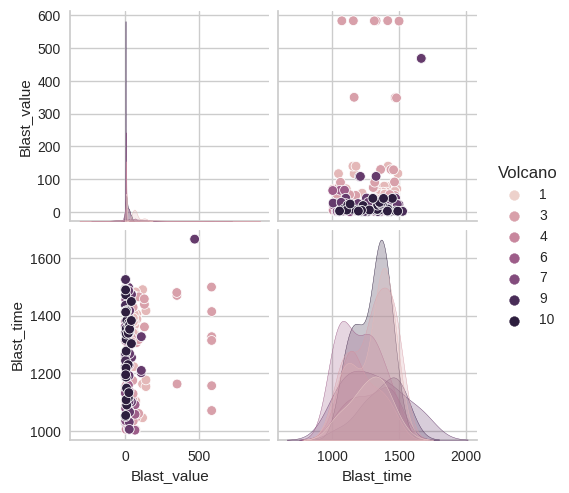

In [37]:
d_pt = prepareBlastTimeTable()
#print(d_pt)

# Analyze  by numeric features
numeric_columns = ['Blast_value','Blast_time']

print(d_pt.shape)
# Analyze the distribution of numeric features
plt.figure(figsize=(10, 4))
sns.pairplot(d_pt[[*numeric_columns, 'Volcano']],hue='Volcano')
#plt.show()

# Perform Regression for Blast values using PyCaret

In order to perform regression, I am pulling the values from two pandas dataframes:


1.   The time interleaved (Sliding window dataframe)
2.   The features dataframe

I am saving 10% of data as unsee data to be used later for cross validation. I am also normalizing the training and test data before running various regressions with PyCaret





In [38]:
sample_size = len(g_observationList)

X = pd.DataFrame()
y = pd.Series([],dtype='float64')

for i in range(sample_size):
  df_h,df_f,ts_f,bt,bv, y_blast, y_time, volcano, observation,M, G, rho, mu, sigma = g_observationList[i]
  ts_f.columns = ts_f.columns.astype(str)
  df2 = pd.concat([ts_f,df_f],axis=1)

  X = pd.concat([X, df2], ignore_index=True)

  y = pd.concat([y,y_blast], ignore_index=True)


print('X_shape =', X.shape)
print('y_shape =' , y.shape)

X = pd.concat([X, y], axis=1, ignore_index=True)

X.columns = list(X.columns[:-1]) + ['y']
print('X_shape =', X.shape)


X_shape = (3306, 1011)
y_shape = (3306,)
X_shape = (3306, 1012)


In [39]:
#Save 10% of unseen data for cross validation
data = X.sample(frac=0.9, random_state=786)
data_unseen = X.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))


from pycaret.regression import *
s = setup(data = data, target = 'y', normalize = True, session_id=123)

Data for Modeling: (2975, 1012)
Unseen Data For Predictions: (331, 1012)


,Description,Value
0,Session id,123
1,Target,y
2,Target type,Regression
3,Original data shape,"(2975, 1012)"
4,Transformed data shape,"(2975, 1012)"
5,Transformed train set shape,"(2082, 1012)"
6,Transformed test set shape,"(893, 1012)"
7,Numeric features,1011
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = compare_models(fold=5)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:42:29
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.9980
lar,Least Angle Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.3080
omp,Orthogonal Matching Pursuit,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.2100
ridge,Ridge Regression,0.0096,0.0002,0.0136,0.9999,0.0086,0.0925,0.3580
gbr,Gradient Boosting Regressor,0.0168,0.0036,0.0579,0.9979,0.0113,0.0860,59.8140
et,Extra Trees Regressor,0.0176,0.0044,0.0662,0.9974,0.0162,0.0437,38.3400
huber,Huber Regressor,0.0479,0.0046,0.0675,0.9972,0.0426,0.4680,2.7100
rf,Random Forest Regressor,0.0148,0.0093,0.0908,0.9946,0.0131,0.0279,110.2920
dt,Decision Tree Regressor,0.0240,0.0120,0.1064,0.9930,0.0200,0.0392,1.4080
br,Bayesian Ridge,0.0597,0.0127,0.0829,0.9918,0.0483,1.0786,1.2480


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.9980
lar,Least Angle Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.3080
omp,Orthogonal Matching Pursuit,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.2100
ridge,Ridge Regression,0.0096,0.0002,0.0136,0.9999,0.0086,0.0925,0.3580
gbr,Gradient Boosting Regressor,0.0168,0.0036,0.0579,0.9979,0.0113,0.0860,59.8140
et,Extra Trees Regressor,0.0176,0.0044,0.0662,0.9974,0.0162,0.0437,38.3400
huber,Huber Regressor,0.0479,0.0046,0.0675,0.9972,0.0426,0.4680,2.7100
rf,Random Forest Regressor,0.0148,0.0093,0.0908,0.9946,0.0131,0.0279,110.2920
dt,Decision Tree Regressor,0.0240,0.0120,0.1064,0.9930,0.0200,0.0392,1.4080
br,Bayesian Ridge,0.0597,0.0127,0.0829,0.9918,0.0483,1.0786,1.2480


From the above tables, it is clear that Linear Regression is the best regression method to be applied for determining blast values. So, I have chosen this method to create a regression model below.

In [28]:
#Create a Linear Regression Model

lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
7,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
8,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_lr = tune_model(lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,68.1353,8661.6979,93.0682,0.3677,0.8188,1.2527
1,70.6920,9503.7774,97.4873,0.3522,0.7581,0.9693
2,75.8379,9997.1239,99.9856,0.2956,0.8703,0.8948
3,67.9217,8252.1594,90.8414,0.3442,1.0707,2.0471
4,68.7202,8867.5970,94.1679,0.1821,0.9559,1.8367
5,59.7578,6797.5559,82.4473,0.5161,0.8852,1.6239
6,69.8414,7971.5628,89.2836,0.3395,0.8673,1.6118
7,79.6899,10402.1444,101.9909,0.2479,0.8945,1.6171
8,65.0790,7204.3994,84.8787,0.4616,0.7623,0.8046


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


**Note:** I tried tuning the above model, but PyCaret declared that the tuning will not help and it recommnded that I use the original model. Hence, I am finalizing this model below.

In [29]:
final_lr = finalize_model(lr)

In [30]:
print(final_lr)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', '10', '11', '12',
                                             '13', '14', '15', '16', '17', '18',
                                             '19', '20', '21', '22', '23', '24',
                                             '25', '26', '27', '28', '29', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator', LinearRegression(n_jobs=-1))])


Now predict the test values based on this model. Note that there are 893 test values. So we will use the model to predict the prediction accuracy with test data. Below if is showing a R2 value of 0.9977 and small error values. This means that the model is performing well.

In [31]:
predict_model(final_lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0379,0.0052,0.0721,0.9978,0.0227,0.2311


,0,1,2,3,4,5,6,7,8,9,...,1003,1004,1005,1006,1007,1008,1009,1010,y,prediction_label
1732,-0.037631,0.142001,0.167145,-0.042351,0.411046,-0.291749,-0.801094,0.016579,-0.138799,0.190210,...,0.993966,-0.000552,-0.000660,0.170329,0.24777,0.22,0.323594,0.25,-0.589146,-0.581669
645,-0.233457,0.233160,0.268944,0.117752,0.115339,0.029494,0.830786,-0.454038,0.706241,0.379905,...,1.779280,-0.000665,-0.000807,0.170329,0.24777,0.22,0.323594,0.50,-0.897975,-0.900648
511,-0.038776,-0.058552,-0.072495,-0.135239,0.638203,0.119611,0.209091,-0.307529,0.054696,0.219271,...,3.321155,0.003360,0.000059,0.282676,0.24777,0.22,0.323594,0.25,3.321155,3.502575
613,0.304997,-0.196646,-0.033187,0.016112,-0.050925,-0.162322,0.087606,-0.008682,0.014012,-0.302942,...,0.348016,-0.000798,-0.000542,0.204780,0.24777,0.22,0.323594,0.10,-0.493130,-0.487661
906,-0.235888,0.097717,0.093938,-0.013822,-0.233088,-0.068653,0.046135,-0.204663,0.007167,0.304997,...,0.348016,-0.000163,0.000193,0.204780,0.24777,0.22,0.323594,0.10,-0.399081,-0.379425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603,0.497438,0.359195,0.310667,-0.041107,-0.715366,-0.535378,0.573267,-0.198793,-0.926754,0.141293,...,2.220861,-0.000526,0.000440,0.204780,0.24777,0.22,0.323594,0.50,-0.028780,-0.006196
2548,0.418341,0.121082,-0.837532,-1.208532,1.441231,0.029063,-0.247561,-0.514282,1.069364,0.013907,...,1.939325,-0.000914,0.000851,0.339851,0.24777,0.22,0.323594,0.50,-0.495995,-0.492761
5,-1.262366,0.111269,-0.236432,0.411607,-0.527121,0.488143,0.209928,0.031656,-0.022255,-1.183050,...,4.711849,0.005757,0.001493,0.204780,0.24777,0.22,0.323594,0.50,4.494780,4.751015
30,-0.048206,-0.019234,-0.230314,-0.046854,-0.195836,-0.048507,0.025169,0.044261,0.105083,-0.114363,...,0.458555,-0.001285,-0.000001,0.339851,0.24777,0.22,0.323594,0.10,-1.332853,-1.358232


Now, let us see how the model does on unseen perdictions. It seems to be predicting stuff correctly.

In [32]:
unseen_predictions = predict_model(final_lr, data=data_unseen)
unseen_predictions.tail()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


,0,1,2,3,4,5,6,7,8,9,...,1003,1004,1005,1006,1007,1008,1009,1010,y,prediction_label
326,-0.854069,0.488420,0.367045,0.559582,1.201539,0.941111,0.403293,0.756738,0.246494,-0.800717,...,1.746365,-0.000384,0.000954,0.339851,0.24777,0.22,0.323594,0.5,-1.237854,-1.237854
327,-0.800717,0.612016,0.260083,0.117658,0.191257,0.167341,0.279827,-0.567773,-0.448013,-0.122627,...,1.746365,-0.000509,0.001076,0.339851,0.24777,0.22,0.323594,0.5,-1.309240,-1.309249
328,-0.459853,-0.128076,-0.173048,-1.334798,-0.295274,0.273437,-0.220316,-0.909857,-0.322292,0.295947,...,1.939385,0.002399,0.001453,0.339851,0.24777,0.22,0.323594,0.5,1.939385,1.939396
329,-0.128076,-0.173048,-1.334798,-0.295274,0.273437,-0.220316,-0.909857,-0.322292,0.295947,-0.038714,...,1.939385,0.001246,-0.001153,0.339851,0.24777,0.22,0.323594,0.5,1.118273,1.118273
330,-0.173048,-1.334798,-0.295274,0.273437,-0.220316,-0.909857,-0.322292,0.295947,-0.038714,-0.677591,...,1.939385,0.000740,-0.000506,0.339851,0.24777,0.22,0.323594,0.5,0.566820,0.566817


The Residual and Error plots below are indicative of a good fit. It may be an overfit.

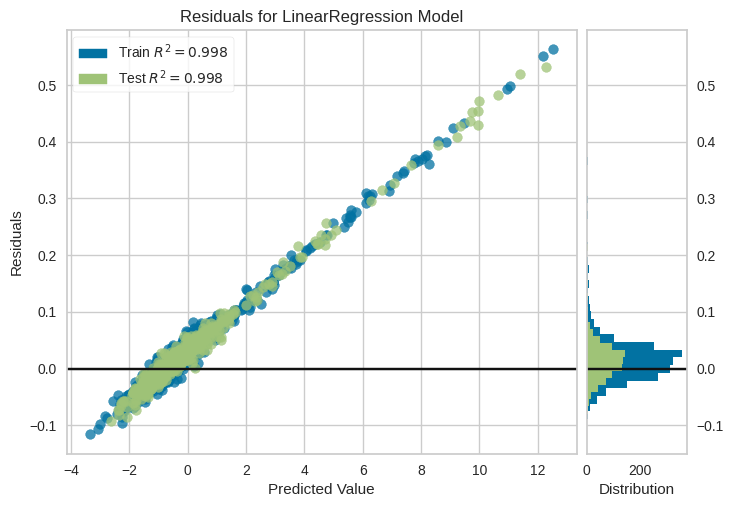

In [34]:
plot_model(final_lr)

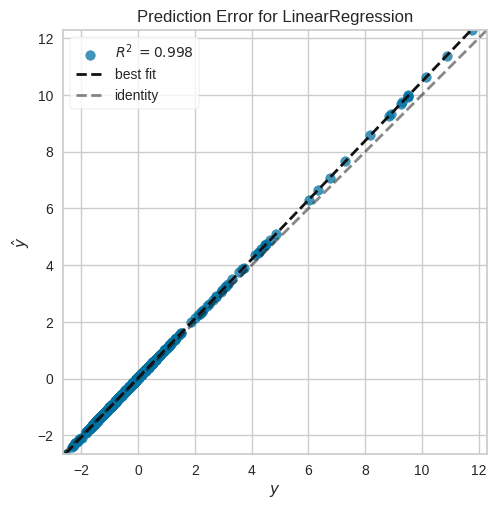

In [35]:
plot_model(final_lr, plot='error')

# Objective 2 - Regression for Time Erupt Values

Here we use the same X matrix as above ans use the time erupt values as the y values

(185, 14)


<Figure size 1000x400 with 0 Axes>

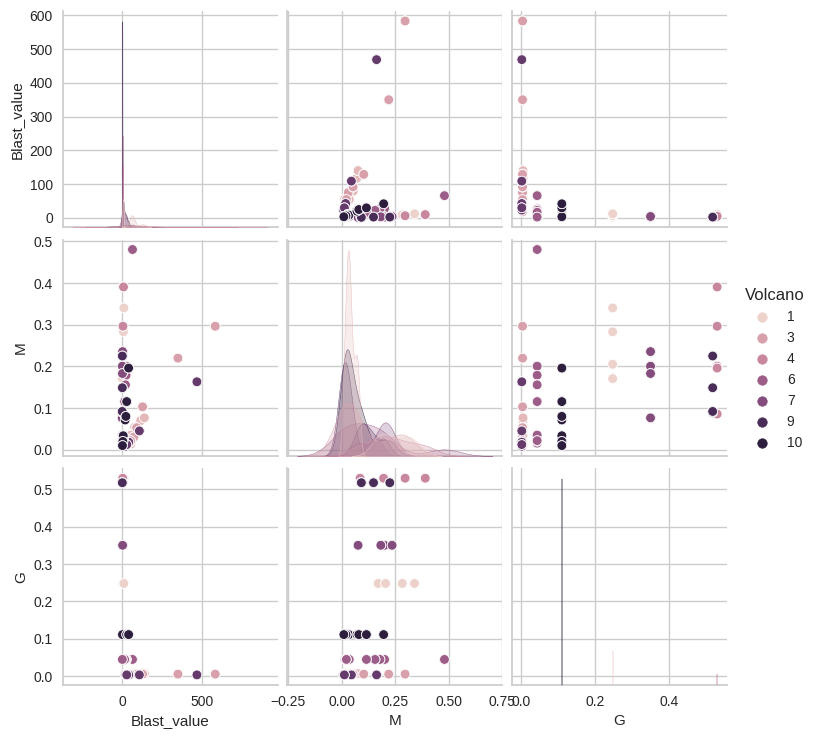

In [40]:
d_pt = prepareBlastTimeTable()
#print(d_pt)

# Analyze  by numeric features
numeric_columns = ['Blast_value','M','G']

print(d_pt.shape)
# Analyze the distribution of numeric features
plt.figure(figsize=(10, 4))
sns.pairplot(d_pt[[*numeric_columns, 'Volcano']],hue='Volcano')
#plt.show()


# Linear Regresion to determine Time to erupt values

Here we perform a Linear Regression using the same X array but a different y Series which contains the time values. Note that 1,000 (the window size) needs to be added to the final prediction to get the correct value.

# PyCaret for Time to Erupt

In [41]:
sample_size = len(g_observationList)

X = pd.DataFrame()
y = pd.Series([],dtype='float64')

for i in range(sample_size):
  df_h,df_f,ts_f,bt,bv, y_blast, y_time, volcano, observation,M, G, rho, mu, sigma = g_observationList[i]
  ts_f.columns = ts_f.columns.astype(str)
  df2 = pd.concat([ts_f,df_f],axis=1)

  X = pd.concat([X, df2], ignore_index=True)

  #y = pd.concat([y,y_blast], ignore_index=True)
  y = pd.concat([y,y_time], ignore_index=True)
  #y_time_train = pd.concat([y_time_train,y_time])


print('X_shape =', X.shape)
print('y_shape =' , y.shape)

X = pd.concat([X, y], axis=1, ignore_index=True)

X.columns = list(X.columns[:-1]) + ['y']
print('X_shape =', X.shape)


X_shape = (3306, 1011)
y_shape = (3306,)
X_shape = (3306, 1012)


Keep 10% of data for cross validation.
Pycaret will treat rest 90% of data and training data and perform a test/train split automatically. Also normalize the data using the default z-scores in Pycaret.

In [42]:
data = X.sample(frac=0.9, random_state=786)
data_unseen = X.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))


from pycaret.regression import *
s = setup(data = data, target = 'y', normalize = True, session_id=123)

Data for Modeling: (2975, 1012)
Unseen Data For Predictions: (331, 1012)


,Description,Value
0,Session id,123
1,Target,y
2,Target type,Regression
3,Original data shape,"(2975, 1012)"
4,Transformed data shape,"(2975, 1012)"
5,Transformed train set shape,"(2082, 1012)"
6,Transformed test set shape,"(893, 1012)"
7,Numeric features,1011
8,Preprocess,True
9,Imputation type,simple


We see below that the Random Forest Regressor is the one which will perform a good job of predicting the erupt times.

In [ ]:
best = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,10.6243,289.9880,17.0044,0.9783,0.2442,0.2129,99.1400
lightgbm,Light Gradient Boosting Machine,11.4929,307.0150,17.4805,0.9770,0.2385,0.2044,38.9060
xgboost,Extreme Gradient Boosting,12.6419,360.7395,18.8995,0.9730,0.2523,0.1871,50.2680
et,Extra Trees Regressor,13.0234,388.8029,19.6272,0.9709,0.2538,0.2042,33.0420
catboost,CatBoost Regressor,15.7357,524.0402,22.8523,0.9607,0.3286,0.2996,316.2920
dt,Decision Tree Regressor,12.8868,536.0080,23.0701,0.9597,0.2961,0.1494,1.3220
gbr,Gradient Boosting Regressor,17.9961,599.1950,24.4547,0.9549,0.3720,0.3425,58.5420
ada,AdaBoost Regressor,35.2597,1604.1350,40.0434,0.8792,0.5955,0.8600,20.8480
lasso,Lasso Regression,40.9593,3179.5420,56.2788,0.7618,0.6560,0.6708,0.5540
llar,Lasso Least Angle Regression,40.9601,3179.5274,56.2787,0.7618,0.6566,0.6709,0.7720


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Let us create and tune the Random Forest Regressor

In [43]:
#Create a Random Forest Regression Model

rf = create_model('rf',fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11.1835,328.2302,18.1171,0.9769,0.1570,0.1048
1,11.2729,319.4320,17.8727,0.9765,0.3185,0.4200
2,10.0862,245.7780,15.6773,0.9804,0.2706,0.2514
3,10.4550,289.2558,17.0075,0.9777,0.2036,0.1493
4,10.1241,267.2441,16.3476,0.9798,0.2710,0.1390
Mean,10.6243,289.9880,17.0044,0.9783,0.2442,0.2129
Std,0.5102,30.9896,0.9148,0.0016,0.0569,0.1145


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_rf = tune_model(rf,fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11.4129,337.2205,18.3636,0.9762,0.1637,0.1097
1,11.6802,355.9051,18.8654,0.9739,0.3343,0.5150
2,10.5848,266.5670,16.3269,0.9787,0.2931,0.2975
3,10.7650,293.4500,17.1304,0.9774,0.2048,0.1520
4,10.4915,277.6417,16.6626,0.9790,0.2821,0.1521
Mean,10.9869,306.1569,17.4698,0.9770,0.2556,0.2453
Std,0.4730,34.5884,0.9818,0.0019,0.0622,0.1492


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [44]:
final_rf = finalize_model(rf)

In [ ]:
print(final_rf)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', '10', '11', '12',
                                             '13', '14', '15', '16', '17', '18',
                                             '19', '20', '21', '22', '23', '24',
                                             '25', '26', '27', '28', '29', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 RandomForestRegressor(n_jobs=-1, random_state=123))])


In [45]:
predict_model(final_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.1077,242.6977,15.5788,0.9815,0.2162,0.0923


,0,1,2,3,4,5,6,7,8,9,...,1003,1004,1005,1006,1007,1008,1009,1010,y,prediction_label
1732,-0.037631,0.142001,0.167145,-0.042351,0.411046,-0.291749,-0.801094,0.016579,-0.138799,0.190210,...,0.993966,-0.000552,-0.000660,0.170329,0.24777,0.22,0.323594,0.25,311,323.69
645,-0.233457,0.233160,0.268944,0.117752,0.115339,0.029494,0.830786,-0.454038,0.706241,0.379905,...,1.779280,-0.000665,-0.000807,0.170329,0.24777,0.22,0.323594,0.50,30,34.03
511,-0.038776,-0.058552,-0.072495,-0.135239,0.638203,0.119611,0.209091,-0.307529,0.054696,0.219271,...,3.321155,0.003360,0.000059,0.282676,0.24777,0.22,0.323594,0.25,10,9.38
613,0.304997,-0.196646,-0.033187,0.016112,-0.050925,-0.162322,0.087606,-0.008682,0.014012,-0.302942,...,0.348016,-0.000798,-0.000542,0.204780,0.24777,0.22,0.323594,0.10,159,159.76
906,-0.235888,0.097717,0.093938,-0.013822,-0.233088,-0.068653,0.046135,-0.204663,0.007167,0.304997,...,0.348016,-0.000163,0.000193,0.204780,0.24777,0.22,0.323594,0.10,168,167.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603,0.497438,0.359195,0.310667,-0.041107,-0.715366,-0.535378,0.573267,-0.198793,-0.926754,0.141293,...,2.220861,-0.000526,0.000440,0.204780,0.24777,0.22,0.323594,0.50,289,279.06
2548,0.418341,0.121082,-0.837532,-1.208532,1.441231,0.029063,-0.247561,-0.514282,1.069364,0.013907,...,1.939325,-0.000914,0.000851,0.339851,0.24777,0.22,0.323594,0.50,192,194.12
5,-1.262366,0.111269,-0.236432,0.411607,-0.527121,0.488143,0.209928,0.031656,-0.022255,-1.183050,...,4.711849,0.005757,0.001493,0.204780,0.24777,0.22,0.323594,0.50,1,7.37
30,-0.048206,-0.019234,-0.230314,-0.046854,-0.195836,-0.048507,0.025169,0.044261,0.105083,-0.114363,...,0.458555,-0.001285,-0.000001,0.339851,0.24777,0.22,0.323594,0.10,107,103.59


In [46]:
unseen_predictions = predict_model(final_rf, data=data_unseen)
unseen_predictions.tail()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.7409,152.0743,12.3318,0.9893,0.2656,0.1036


,0,1,2,3,4,5,6,7,8,9,...,1003,1004,1005,1006,1007,1008,1009,1010,y,prediction_label
326,-0.854069,0.488420,0.367045,0.559582,1.201539,0.941111,0.403293,0.756738,0.246494,-0.800717,...,1.746365,-0.000384,0.000954,0.339851,0.24777,0.22,0.323594,0.5,51,51.68
327,-0.800717,0.612016,0.260083,0.117658,0.191257,0.167341,0.279827,-0.567773,-0.448013,-0.122627,...,1.746365,-0.000509,0.001076,0.339851,0.24777,0.22,0.323594,0.5,42,50.84
328,-0.459853,-0.128076,-0.173048,-1.334798,-0.295274,0.273437,-0.220316,-0.909857,-0.322292,0.295947,...,1.939385,0.002399,0.001453,0.339851,0.24777,0.22,0.323594,0.5,23,23.06
329,-0.128076,-0.173048,-1.334798,-0.295274,0.273437,-0.220316,-0.909857,-0.322292,0.295947,-0.038714,...,1.939385,0.001246,-0.001153,0.339851,0.24777,0.22,0.323594,0.5,22,25.04
330,-0.173048,-1.334798,-0.295274,0.273437,-0.220316,-0.909857,-0.322292,0.295947,-0.038714,-0.677591,...,1.939385,0.000740,-0.000506,0.339851,0.24777,0.22,0.323594,0.5,21,22.13


The residual and error plots are indicative of a good fit. It may be an overfit.

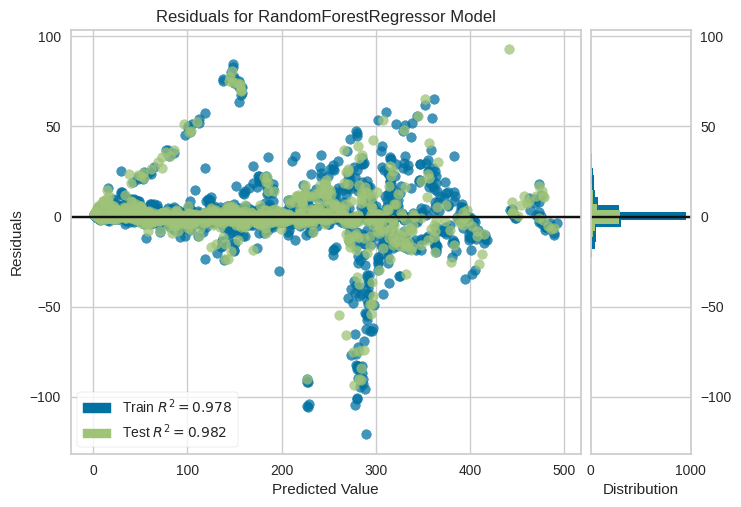

In [47]:
plot_model(final_rf)

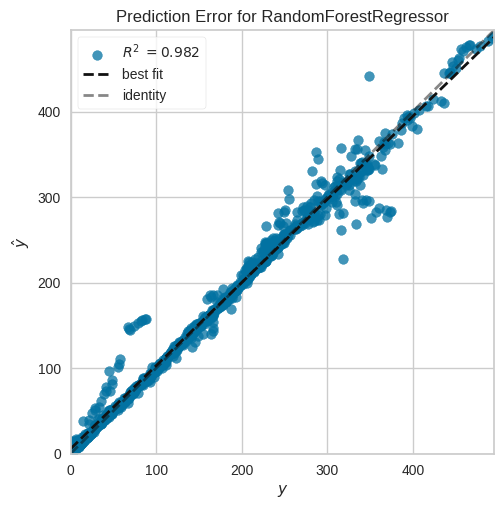

In [48]:
plot_model(final_rf, plot='error')

# Conclusion and Final Remarks
In general, I spent lot of time with data management and data transformation and less time on optimizing regression models. It is good that Pycaret was suggested by the instructor. This simplified the work of running regressions.

The approach that I took was to perform regression of one Volcano at a time. Here, I have performed the regressions for Volcano 1 and learned that Linear Regression is the best method for determining Blast values with an average R2 value of 0.99. I also learned that Random Forest Regression is the best method for determining the Erupt time with an average R2 value of 0.98